# Exploratory Data Analysis (EDA)

Since the dataset has already been split, this notebook focuses only on `train.csv`.  
Restricting EDA to the training set helps prevent data leakage and ensures that any decisions about feature engineering, modeling, or threshold selection remain unbiased.

During EDA, the goal is to build a general intuition about the data — its structure, content, and potential issues. This includes understanding variable types, common value ranges, missing data, and potential early signals of anomalies or bot activity.


In [1]:
# dependencies
import pandas as pd
import numpy as np
import pickle

# data profiling
from ydata_profiling import ProfileReport

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# use inline backend for matplotlib
%matplotlib inline

# set display options for full output
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Don't wrap wide tables
pd.set_option('display.max_colwidth', None)  # Show full content in cells

In [3]:
df = pd.read_csv(
    '../data/train.csv',
    sep='\t',
    index_col=False,
)
df.head()

,datetime,region,browser,device,url_params
0,2019-12-02 00:00:01,Mercury,Safari,Android,/ad_click?n=1&f=1&d=www.ashtondrake.com&sld=1&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=2297&q=frit%20sewn%20quipu&ct=JP&kl=wt-wt&kp=-1
1,2019-12-02 00:00:02,Venus,Chrome,Android,/ad_click?n=1&f=1&d=www.viagogo.com.mx&sld=1&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=1799&q=nold%20fn%20eques%20campoo%20mortality%20tawgi&ct=MX&kl=wt-wt&kp=-1&bkl=r1-2
2,2019-12-02 00:00:17,Mars,Edge,Android,/ad_click?n=1&f=1&d=www.AliExpress.com&sld=1&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=27721&q=splenocyte&ct=FR&kl=wt-wt&kp=-1
3,2019-12-02 00:00:44,Venus,Edge,Android,/ad_click?n=1&f=1&d=www.amazon.ca&sld=0&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=2534&q=diau%20haeing%20sah&ct=CA&kl=wt-wt&kp=-1
4,2019-12-02 00:00:49,Mars,Safari,Android,/ad_click?n=1&f=1&d=www.uswitch.com&sld=0&st=mobile_search_intl&nt=0&r=0&adx=oag&adx_name=none&ttc=7144&q=stirrable%20ocher&ct=GB&kl=uk-en&kp=-1


### Automated EDA

For the initial step, the `ydata-profiling` library is used to generate an automated exploratory report that provides a quick overview of dataset structure, variable types, distributions, missing values, and potential outliers.

For the initial report, the search parameter column is excluded as it is too complex for the library to summarize meaningfully.

In [4]:
profile = ProfileReport(df.drop(columns=['url_params']))
profile.to_file('01-1-initial_automated_eda.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 25.38it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Initial Findings:
- No missing data  
- Some duplicated rows _(to be verified against the full dataset)_  
- Browser and device features show strong categorical association (**Cramér’s V = 0.782**)  
- `region`: 6 distinct values, mostly either **Mars** or **Earth**  
- `device`: values are either **Android** or **iOS**, mostly **Android**  
- `browser`: 5 distinct values, with **Chrome** being the most common
- For all three categorical features, values are standardized (i.e., no mixed casing, extra whitespace, etc.)

#### Duplicated data

In [5]:
print(f"There are {df.duplicated().sum()} duplicated rows.")

There are 9 duplicated rows.


If these reflect true user or bot behavior (e.g., repeated identical clicks), they may be relevant for model fitting or frequency-based features.  
Otherwise, they could indicate logging artifacts or a system error.

In [6]:
# look into duplicated rows
df_duplicated = df[df.duplicated()]
df_duplicated

,datetime,region,browser,device,url_params
6269,2019-12-02 09:55:53,Mars,Chrome,Android,/ad_click?n=1&f=1&d=www.amazon.es&sld=0&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=969&q=brisker%20napa&ct=ES&kl=wt-wt&kp=-1
6272,2019-12-02 09:56:00,Mars,Safari,Android,/ad_click?n=1&f=1&d=www.northwickassociates.co.uk&sld=1&st=mobile_search_intl&nt=0&r=0&adx=def&adx_name=none&ttc=14816&q=otopiesis%20probit&ct=GB&kl=wt-wt&kp=-1
6281,2019-12-02 09:56:46,Mars,Chrome,Android,/ad_click?n=1&f=1&d=www.berghof.at&sld=0&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=15281&q=cudgels%20kras&ct=NL&kl=wt-wt&kp=-2
9171,2019-12-02 13:20:23,Earth,Chrome,Android,/ad_click?n=1&f=1&d=hausbau.musterhaus.net&sld=0&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=9795&q=nonretentive%20doited&ct=DE&kl=wt-wt&kp=-1
9176,2019-12-02 13:20:41,Earth,Chrome,Android,/ad_click?n=1&f=1&d=hausbau.musterhaus.net&sld=0&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=5131&q=nonretentive%20doited&ct=DE&kl=wt-wt&kp=-1&bkl=ra-0
9189,2019-12-02 13:21:04,Earth,Chrome,Android,/ad_click?n=1&f=1&d=samsclub.com&sld=1&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=15313&q=invade%20houri%20tanan&ct=DE&kl=wt-wt&kp=-1
9904,2019-12-02 14:08:34,Mars,Chrome,Android,/ad_click?n=1&f=1&d=www.yidio.com&sld=1&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=7756&q=loco%20rander%20onflow%20f%20myoneme%20iq&ct=GB&kl=wt-wt&kp=-1&lsexp1=b
11665,2019-12-02 15:50:50,Mars,Edge,Android,/ad_click?n=1&f=1&d=www.amazon.de&sld=0&st=mobile_search_intl&nt=0&r=null&adx=def&adx_name=none&ttc=521&q=ipr%20alemannian%20nubbled&ct=DE&kl=wt-wt&kp=-1&bkl=r1-1
11669,2019-12-02 15:50:59,Mars,Chrome,Android,/ad_click?n=1&f=1&d=www.cargurus.co.uk&sld=1&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=3667&q=attendance%20kae&ct=GB&kl=wt-wt&kp=-1


For further EDA, duplicated rows will be removed. This may be revisited later for behavioral analysis or clustering.

In [7]:
df = df.drop_duplicates()
df.shape

(11711, 5)

### `datetime`
While automated report gave already good insight into time period we have in the training set, I want to see ution by hour.  

In [8]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.loc[:, 'date'] = df['datetime'].dt.date
df.loc[:, 'time'] = df['datetime'].dt.time
df.loc[:, 'hour'] = df['datetime'].dt.hour

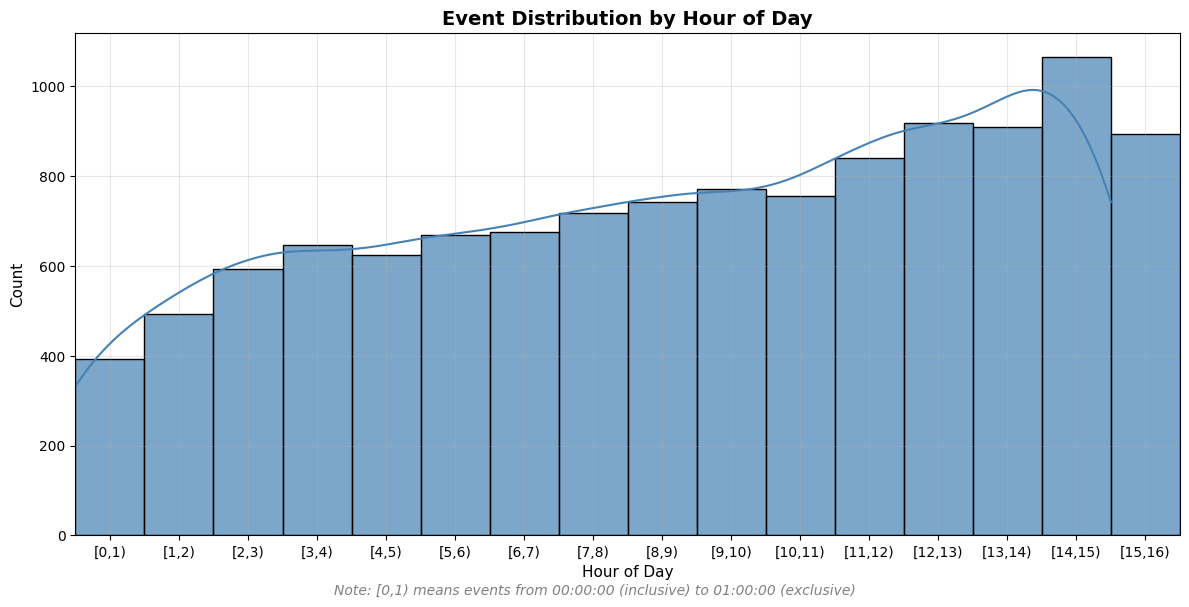

Data spans from hour 0 to hour 15
Total hours with data: 16
Timestamp of the first observation: 2019-12-02 00:00:01
Timestamp of the last observation: 2019-12-02 15:53:39


In [9]:
plt.figure(figsize=(12, 6))

# Get the actual range of hours in your data
min_hour = df['hour'].min()
max_hour = df['hour'].max()
hour_range = max_hour - min_hour + 1

# Create explicit bin edges to ensure proper alignment
bin_edges = np.arange(min_hour, max_hour + 2, 1)  # +2 to include the last hour

# Create histogram with seaborn - use actual number of hours
sns.histplot(data=df, x='hour', bins=bin_edges, kde=True, color='steelblue', alpha=0.7)

# Customize
plt.title('Event Distribution by Hour of Day', fontsize=14, fontweight='bold')
plt.figtext(
    0.5,
    0.001,
    'Note: [0,1) means events from 00:00:00 (inclusive) to 01:00:00 (exclusive)', 
    ha='center',
    fontsize=10,
    style='italic',
    color='gray',
)
plt.xlabel('Hour of Day', fontsize=11)
plt.ylabel('Count', fontsize=11)

# Create proper x-tick labels with intervals for actual hours
tick_labels = [f'[{int(bin_edges[i])},{int(bin_edges[i+1])})' for i in range(len(bin_edges)-1)]
tick_positions = bin_edges[:-1] + 0.5
plt.xticks(tick_positions, tick_labels)

# Set x-axis limits to match your data range
plt.xlim(min_hour, max_hour + 1)

# Add grid
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Data spans from hour {min_hour} to hour {max_hour}")
print(f"Total hours with data: {hour_range}")
print(f"Timestamp of the first observation: {df['datetime'].min()}")
print(f"Timestamp of the last observation: {df['datetime'].max()}")

While the histogram shows a clear increase in event volume during certain hours (with a spike around the last full hour: 14:00–15:00), it's important to acknowledge that we do not have information about the original timezones of the users or events.

The timestamps may reflect server time or a standardized time (e.g., UTC), not the actual local time of users. As such, any behavioral interpretation (e.g., "morning usage", "lunch spike") is speculative.

That said, relative anomalies — such as sharp bursts or sudden drops — can still be useful indicators of unusual activity, even without timezone alignment.


### Search parameters

To properly analyze the search parameters, each parameter and its corresponding value needs to be extracted.

In [ ]:
def parse_url_params_simple(url_string: str) -> dict:
    """
    Simple param parsing.
    Save all params by their title and their value, and the first part of the url as prefix.

    Assumption: input string follows pattern similar to:
    /[a-zA-Z0-9_]+[?]([a-zA-Z0-9_]+=[^&]+&?)*

    Examples:
    /search?q=test&f=1
    /ad_click?n=1&f=1&d=www.amazon.com

    Expected output:
    {
        "__prefix__": "search",
        "q": "test",
        "f": "1",
    }
    """
    result = {}

    if '?' not in url_string:
        return result
    
    # get everything after ?
    query_parts = url_string.split('?')
    result["__prefix__"] = query_parts[0]
    query_part = query_parts[1]
    
    # split by &
    param_pairs = query_part.split('&')
    
    for pair in param_pairs:
        if '=' in pair:
            key, value = pair.split('=', 1)
            result[key] = value
    
    return result


In [11]:
df.loc[:, 'params_dict'] = df['url_params'].apply(parse_url_params_simple)

# print one set of parameters
df['params_dict'].values[0]

{'__prefix__': '/ad_click',
 'n': '1',
 'f': '1',
 'd': 'www.ashtondrake.com',
 'sld': '1',
 'st': 'mobile_search_intl',
 'nt': '0',
 'r': '0',
 'adx': 'none',
 'adx_name': 'none',
 'ttc': '2297',
 'q': 'frit%20sewn%20quipu',
 'ct': 'JP',
 'kl': 'wt-wt',
 'kp': '-1'}

In [12]:
# check frequency each parameter
# flatten all dictionaries and count keys
all_keys_series = df['params_dict'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else [])
all_keys_flat = [key for keys_list in all_keys_series for key in keys_list]

# get frequency of each parameter and percentage of missing values 
# in correspondence with the total number of rows in dataset
pd.Series(all_keys_flat)\
    .value_counts()\
    .to_frame("count")\
    .assign(missing_values_percentage=lambda x: round((1 - x["count"] / df.shape[0]) * 100, 2))

,count,missing_values_percentage
__prefix__,11711,0.00
n,11711,0.00
d,11711,0.00
sld,11711,0.00
st,11711,0.00
nt,11711,0.00
kp,11711,0.00
r,11711,0.00
adx,11711,0.00
adx_name,11711,0.00


The dataset includes a set of query parameters extracted from ad click URLs. Most fields are abbreviated, and their actual meanings are not provided in the assignment's instructions. In this context, their interpretation is based on:
- Inferred patterns from their values and distributions
- Naming conventions commonly used in search and ad tech
- Supportive interpretation via tools like ChatGPT

In a real-world scenario, the exact purpose and encoding of these parameters would be validated through engineering documentation or by consulting the logging/tracking system owners.

From an exploratory perspective:
- Core fields such as `q` (search query), `ttc` (time to click), and `d` (destination domain) appear on all records and can be confidently treated as primary behavioral features.
- Other parameters (e.g., `bkl`, `atbva`, `va`, etc.) have very sparse coverage and may correspond to experimental flags, attribution tags, or internal metadata. These may still provide useful signals if their presence aligns with anomalous patterns, but caution is required due to their high missingness and uncertain semantics.

In [13]:
# transform from dictionary into dataframe
df_full = df.join(df['params_dict'].apply(pd.Series))
df_full.drop(columns=['url_params', 'params_dict'], inplace=True)
df_full.columns

Index(['datetime', 'region', 'browser', 'device', 'date', 'time', 'hour',
       '__prefix__', 'n', 'f', 'd', 'sld', 'st', 'nt', 'r', 'adx', 'adx_name',
       'ttc', 'q', 'ct', 'kl', 'kp', 'bkl', 'lsexp1', 'om', 'atb', 'atbva',
       'va', 'atbexp'],
      dtype='object')

In [14]:
df_full.head()

,datetime,region,browser,device,date,time,hour,__prefix__,n,f,d,sld,st,nt,r,adx,adx_name,ttc,q,ct,kl,kp,bkl,lsexp1,om,atb,atbva,va,atbexp
0,2019-12-02 00:00:01,Mercury,Safari,Android,2019-12-02,00:00:01,0,/ad_click,1,1,www.ashtondrake.com,1,mobile_search_intl,0,0,none,none,2297,frit%20sewn%20quipu,JP,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-12-02 00:00:02,Venus,Chrome,Android,2019-12-02,00:00:02,0,/ad_click,1,1,www.viagogo.com.mx,1,mobile_search_intl,0,0,none,none,1799,nold%20fn%20eques%20campoo%20mortality%20tawgi,MX,wt-wt,-1,r1-2,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-12-02 00:00:17,Mars,Edge,Android,2019-12-02,00:00:17,0,/ad_click,1,1,www.AliExpress.com,1,mobile_search_intl,0,0,none,none,27721,splenocyte,FR,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-12-02 00:00:44,Venus,Edge,Android,2019-12-02,00:00:44,0,/ad_click,1,1,www.amazon.ca,0,mobile_search_intl,0,0,none,none,2534,diau%20haeing%20sah,CA,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-02 00:00:49,Mars,Safari,Android,2019-12-02,00:00:49,0,/ad_click,1,1,www.uswitch.com,0,mobile_search_intl,0,0,oag,none,7144,stirrable%20ocher,GB,uk-en,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now that all parameters are split into separate columns, automated EDA can be re-run.

Two columns — `d` (destination domain) and `q` (query) — are excluded from the report,
as they contain a high number of unique values. The profiling library attempts to
compute word frequencies for such fields, which will actually throw an error and generally
wouldn't be that useful at this stage.

In [15]:
# quick fix for time column, otherwise library throws an error that
# time is not supported format.
df_full["time"] = df_full["time"].astype(str)

In [16]:
profile = ProfileReport(df_full.drop(columns=['d', 'q']))
profile.to_file('01-2-automated_eda_on_full_dataframe.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:04<00:00,  6.33it/s]
/home/home/Documents/_git/ddg-home-assignment/.venv/lib/python3.12/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 9 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Summary of Automated EDA


- No missing values* in most core fields. All required columns are populated and valid.
- Several fields are constants, e.g., `date`, `__prefix__`, `st`, `f`, `atb`, `atbexp`, which may offer little value for modeling and can likely be excluded from feature engineering.
- Some fields are highly sparse and correlated, especially `atbva`, `bkl`, `lsexp1`, `om`, `va`, etc. Many of these are >90% missing and strongly correlated with each other. These likely represent flags or experimental conditions and will be assessed for binary encoding or exclusion.
- Many fields are highly imbalanced, such as `n`, `nt`, `r`, `adx_name`, `adx`, etc. While potentially useful for detecting anomalous traffic patterns, care will be taken to avoid overfitting on rare categories.
- `ttc` (assuming: time to click) is extremely skewed (γ₁ = 66+), suggesting it could benefit from log transformation or outlier clipping. Despite skew, it likely carries strong behavioral signal.
- Region, device, and browser fields are clean and low in cardinality. Device and browser are somewhat imbalanced but still useful. Correlation between browser/device suggests possible device fingerprinting patterns.
- Temporal feature (`datetime`) is valid, with no missing or invalid timestamps. However, `date` is constant, which limits time-series modeling.
- High multicollinearity is observed among many fields. Correlation structures will be monitored closely during feature selection to avoid redundancy or model instability.
- Text fields (`q`, `d`) were excluded from automated profiling due to high cardinality, but will be explored during feature engineering.

---

Additional Observations

- The entire dataset occurs on a single day (2019-12-02). Therefore, no time-series modeling will be done. However, temporal order still matters for anomaly detection and will be preserved (as already noted during the data split phase in the previous notebook).

- Some categorical fields like adx_name, va, atbva appear system-generated or anonymized — this introduces noise but could still hold indirect signals.


In [17]:
# pass final state of dataframe to the next notebook
with open('../data/tmp_eda_full_df.pkl', 'wb') as f:
    pickle.dump(df, f)